### 这是专门用来绘制TRANSAID文章图的脚本

#### Fig1

In [1]:
# 加载必要的包
library(ggplot2)
library(reshape2)
library(pheatmap)
library(scales)
library(grid)
library(gridExtra)
library(dplyr)

Warning message:
“package ‘gridExtra’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
### confusion matrix ###
###########################
# 创建并保存混淆矩阵图的函数，添加参数prefix用于指定保存图片文件名的前缀，添加参数custom_confusion_data用于接收自定义的混淆矩阵数据
create_and_save_confusion_matrix <- function(prefix, custom_confusion_data) {
  # 设置行列名
  rownames(custom_confusion_data) <- c("Start_Codon(TIS)", "Stop_Codon(TTS)", "Non-TTS/TIS")
  colnames(custom_confusion_data) <- c("Start_Codon(TIS)", "Stop_Codon(TTS)", "Non-TTS/TIS")

  # 转换为长格式数据
  confusion_long <- melt(custom_confusion_data)
  colnames(confusion_long) <- c("Predicted", "True", "Value")

  # 计算总数
  totals <- c(
    "Total Start_Codon(TIS) num" = sum(custom_confusion_data[,1]),
    "Total Stop_Codon(TTS) num" = sum(custom_confusion_data[,2]),
    "Total Non-TTS/TIS num" = sum(custom_confusion_data[,3])
  )

  # 创建混淆矩阵图
  conf_plot <- ggplot(confusion_long, aes(x = True, y = Predicted)) +
    geom_tile(aes(fill = Value), color = "black", linewidth = 1) +
    geom_text(aes(label = Value, color = Value > 5e6), size = 4) +
    scale_fill_gradient(low = "white", high = "navy") +
    scale_color_manual(values = c("black", "white"), guide = "none") + 
    theme_minimal() +
    labs(#title = "TRANSAID_Embedding_batch4_NM Confusion Matrix in Base Level",
         x = "True label",
         y = "Predicted label") +
    theme(axis.text.x = element_text(angle = 30, hjust = 1, size=16, color = "black"),
          axis.text.y = element_text(size=16, color = "black"),
          plot.title = element_text(hjust = 0.5)) +
    guides(fill = guide_colorbar(title = "Value",
                                 barwidth = 1,
                                 barheight = 10))

  # 保存图片，使用传入的prefix来构造文件名
  ggsave(paste0(prefix, "_confusion_matrix.png"), conf_plot, width = 7, height = 6, dpi = 600)
}

In [3]:
### confusion performance ###
#############################
# 计算性能指标函数，添加参数conf_matrix用于接收传入的混淆矩阵数据
calc_metrics <- function(conf_matrix) {
  # 计算每个类别的指标
  n <- nrow(conf_matrix)
  precision <- diag(conf_matrix) / colSums(conf_matrix)
  recall <- diag(conf_matrix) / rowSums(conf_matrix)
  f1_score <- 2 * (precision * recall) / (precision + recall)
  
  # 计算宏平均
  macro_precision <- mean(precision)
  macro_recall <- mean(recall)
  macro_f1 <- mean(f1_score)
  
  # 创建性能矩阵
  perf_matrix <- rbind(
    c(macro_precision, precision),
    c(macro_recall, recall),
    c(macro_f1, f1_score)
  )
  
  rownames(perf_matrix) <- c("Precision", "Recall", "F1-score")
  colnames(perf_matrix) <- c("Macro Average", "Start_Codon(TIS)", 
                            "Stop_Codon(TTS)", "Non-TTS/TIS")
  
  return(perf_matrix)
}

# 准备性能矩阵数据函数，添加参数perf_matrix用于接收性能矩阵数据（可由上一个函数计算得到）
create_performance_data <- function(perf_matrix) {
    # 将矩阵转换为长格式
    perf_long <- melt(perf_matrix)
    colnames(perf_long) <- c("Metric", "Category", "Value")
    
    # 确保因子水平的顺序
    perf_long$Metric <- factor(perf_long$Metric, 
                             levels = c("Precision", "Recall", "F1-score"))
    perf_long$Category <- factor(perf_long$Category, 
                               levels = c("Macro Average", "Start_Codon(TIS)", 
                                        "Stop_Codon(TTS)", "Non-TTS/TIS"))
    
    return(perf_long)
}

# 创建性能矩阵热图函数，添加参数perf_long用于接收处理好的长格式性能矩阵数据
create_performance_heatmap <- function(perf_long) {
    ggplot(perf_long, aes(x = Category, y = Metric, fill = Value)) +
        geom_tile(color = "gray", linewidth = 1) +
        geom_text(aes(label = sprintf("%.4f", Value),
                     color = ifelse(Value >= 0.9, "white", "black")), 
                 size = 4) +
        scale_fill_gradient(low = "white", high = "navy",
                          limits = c(0.75, 1),
                          breaks = seq(0.75, 1, 0.05)) +
        scale_color_identity() +
        labs(#title = "TRANSAID_Embedding_batch4_NM Performance Matrix in Base Level",
             x = "",
             y = "") +
        theme_minimal() +
        theme(
            plot.title = element_text(hjust = 0.5, size = 14),
            axis.text.x = element_text(angle = 30, hjust = 1, size = 16, color = "black"),
            axis.text.y = element_text(size = 16, color = "black"),
            #legend.title = element_text(size = 12),
            legend.text = element_text(size = 10),
            legend.position = "right",
            panel.grid = element_blank()
        ) +
        guides(fill = guide_colorbar(title = "",
                                   barwidth = 1,
                                   barheight = 10))
}

# 主函数，整合整个流程，接收图片保存的前缀参数和自定义的混淆矩阵数据
generate_and_save_performance_plot <- function(prefix, custom_confusion_data) {
    # 计算性能矩阵，使用传入的自定义混淆矩阵数据
    perf_matrix <- calc_metrics(custom_confusion_data)
    
    # 准备性能矩阵数据
    perf_long <- create_performance_data(perf_matrix)
    
    # 创建性能矩阵图
    perf_plot <- create_performance_heatmap(perf_long)
    
    # 保存图片，使用传入的前缀来构造文件名
    ggsave(paste0(prefix, "_performance_matrix.png"), perf_plot, width = 7, height = 6, dpi = 600)
    
    # 返回绘图对象
    return(perf_plot)
}

In [4]:
###  performance in ORF accuarcy###
#############################

# 准备性能数据
create_transcript_performance_data <- function(ORF_data) {
    # 从ORF_data中提取数据
    performance_data <- data.frame(
        group = paste0("group", seq_len(length(ORF_data$results))),
        description = names(ORF_data$results),
        count = unlist(ORF_data$results),
        stringsAsFactors = FALSE
    )
    
    # 计算比率
    performance_data$ratio <- performance_data$count / ORF_data$total
    
    # 设置颜色
    performance_data$color <- c("#000080","#8FBC8F", "#FFC0CB", "#FFA07A", "#D8BFD8")[1:nrow(performance_data)]
    return(performance_data)
}

# 创建性能条形图
create_transcript_performance_plot <- function(performance_data, prefix) {
    # 创建标签
    labels <- sprintf("%d\n(%.2f%%)", 
                     performance_data$count, 
                     performance_data$ratio * 100)
    
    # 创建图形
    p <- ggplot(performance_data, aes(x = group, y = ratio, fill = group)) +
        geom_bar(stat = "identity") +
        geom_text(aes(label = labels,
                     y = ifelse(ratio < 0.9,
                               ratio + 0.02,
                               ratio / 2 + 0.02),
                     vjust = ifelse(ratio < 0.9, 0, 0.2)),
                 size = 5,
                 color = ifelse(performance_data$group == "group1" & performance_data$ratio > 0.9, "white", "black")) +
        scale_fill_manual(values = performance_data$color,
                         labels = sprintf("%s: %s", 
                                        performance_data$group, 
                                        performance_data$description)) +
        labs(#title = sprintf("%s Accuracy in Triplet Codon Level", prefix),
             x = "Performance Category",
             y = "Ratio",
            size = 16,
            color = "black") +
        theme_minimal() +
        theme(
            #plot.title = element_text(hjust = 0.5, size = 14),
            axis.text.x = element_text(size = 14, color = "black"),
            axis.text.y = element_text(size = 14, color = "black"),
            axis.title = element_text(size = 16),
            legend.title = element_blank(),
            legend.position = c(0.65, 0.8),
            legend.text = element_text(size = 14),
            panel.grid.major.x = element_blank(),
            panel.grid.minor = element_blank(),
            legend.key.width = unit(1, "cm"),
            # 设置 Y 轴轴线不出头且范围固定在 0 到 1
            axis.line.y = element_line(color = "black", linewidth = 1, arrow = arrow(length = unit(0, "cm"))),
            axis.ticks.y = element_line(color = "black", linewidth = 0.5),
            axis.ticks.length.y = unit(0.2, "cm"),
            axis.ticks.minor.y = element_line(color = "gray", linewidth = 0.3),
            axis.ticks.length.minor.y = unit(0.1, "cm")
        ) +
        # 固定 Y 轴范围为 0 到 1
        scale_y_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1.0), limits = c(0, 1),
                           expand = expansion(mult = c(0, 0)))
    # 移除多余的图例项
    p <- p + guides(color = FALSE)
    return(p)
}

# 主执行函数
plot_transcript_performance <- function(ORF_data, prefix) {
    # 准备数据
    performance_data <- create_transcript_performance_data(ORF_data)
    
    # 创建图形
    perf_plot <- create_transcript_performance_plot(performance_data, prefix)
    
    # 保存图形
    ggsave(
        filename = sprintf("%s_triplet_performance.png", prefix),
        plot = perf_plot,
        width = 8,
        height = 6,
        dpi = 600
    )
    
    # 返回图形对象
    return(perf_plot)
}

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2 3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in

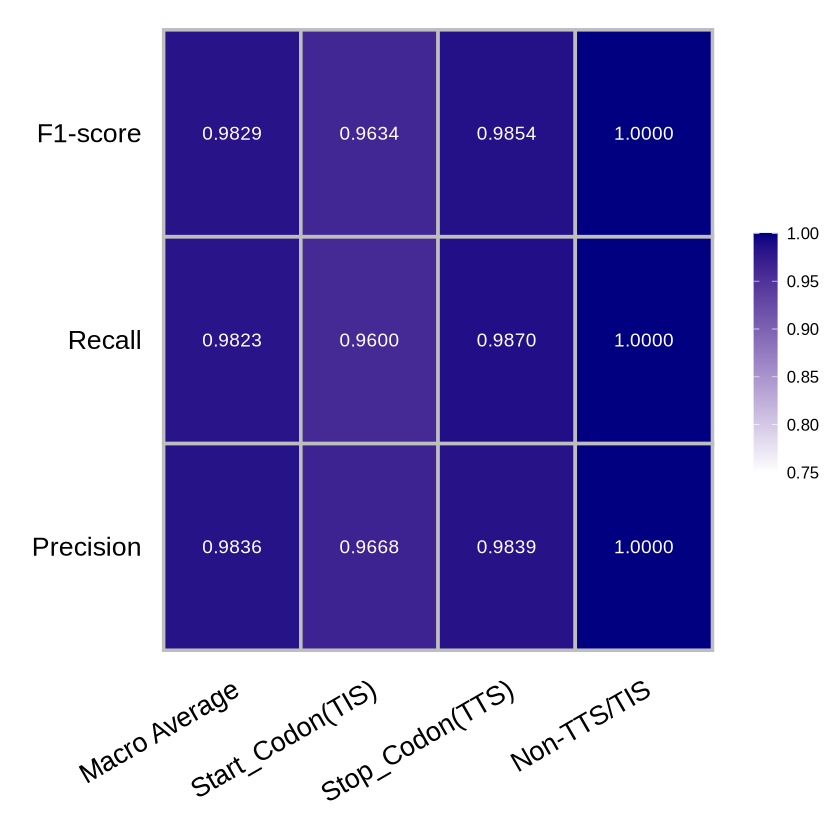

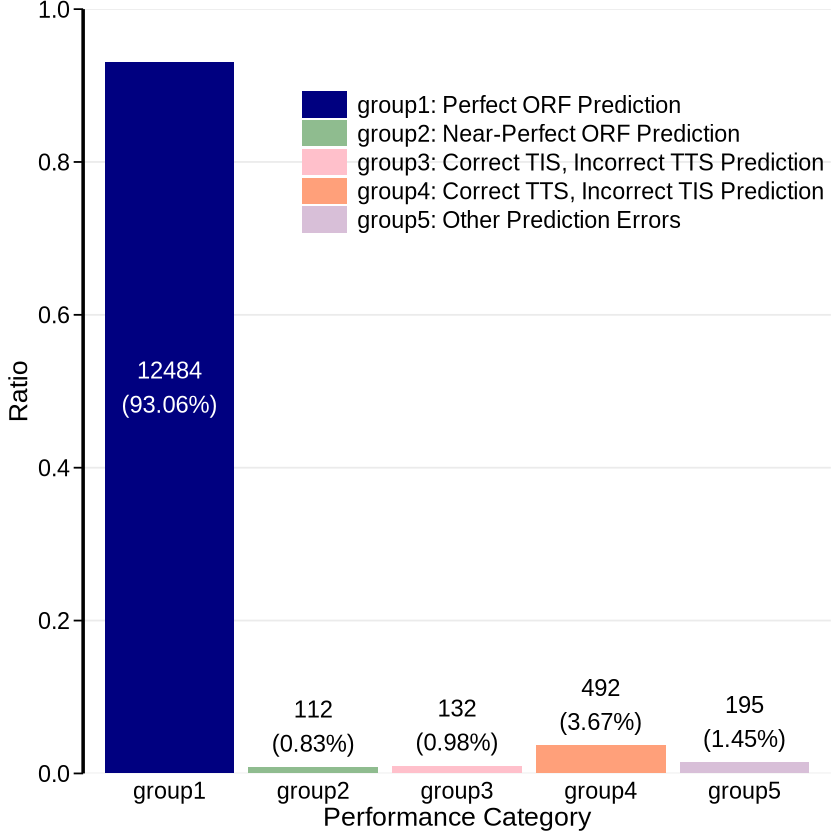

In [5]:
# 示例数据
confusion_data <- matrix(c(
  38636, 9, 1600,
  1, 39720, 524,
  1324, 643, 52703653
), nrow = 3, byrow = TRUE)

# 调用函数，传入前缀和自定义的混淆矩阵数据
create_and_save_confusion_matrix("TRANSAID_Embedding_batch4_TrainOnlyNM_NM", confusion_data)
generate_and_save_performance_plot("TRANSAID_Embedding_batch4_TrainOnlyNM_NM", confusion_data)
 ORF_data_1nm <- list(
          results = list(
         "Perfect ORF Prediction" = 12484,
         "Near-Perfect ORF Prediction" = 112,
         "Correct TIS, Incorrect TTS Prediction" = 132,
         "Correct TTS, Incorrect TIS Prediction" = 492,
         "Other Prediction Errors" = 195
     ),
     total = 13415
)
plot_transcript_performance(ORF_data_1nm, "TRANSAID_Embedding_batch4_TrainOnlyNM_NM")

Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”


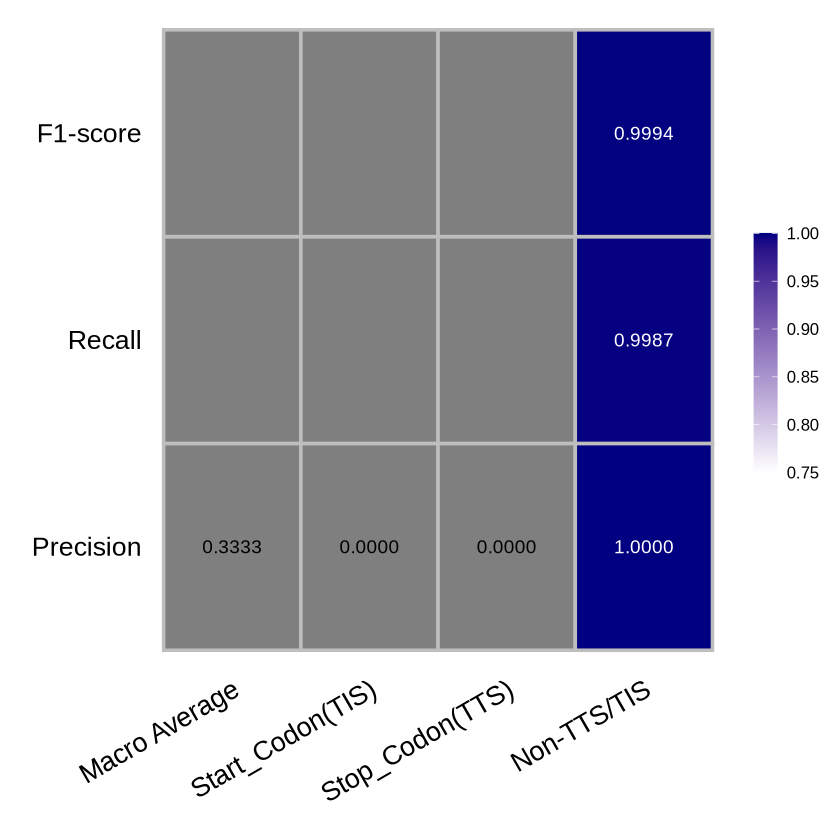

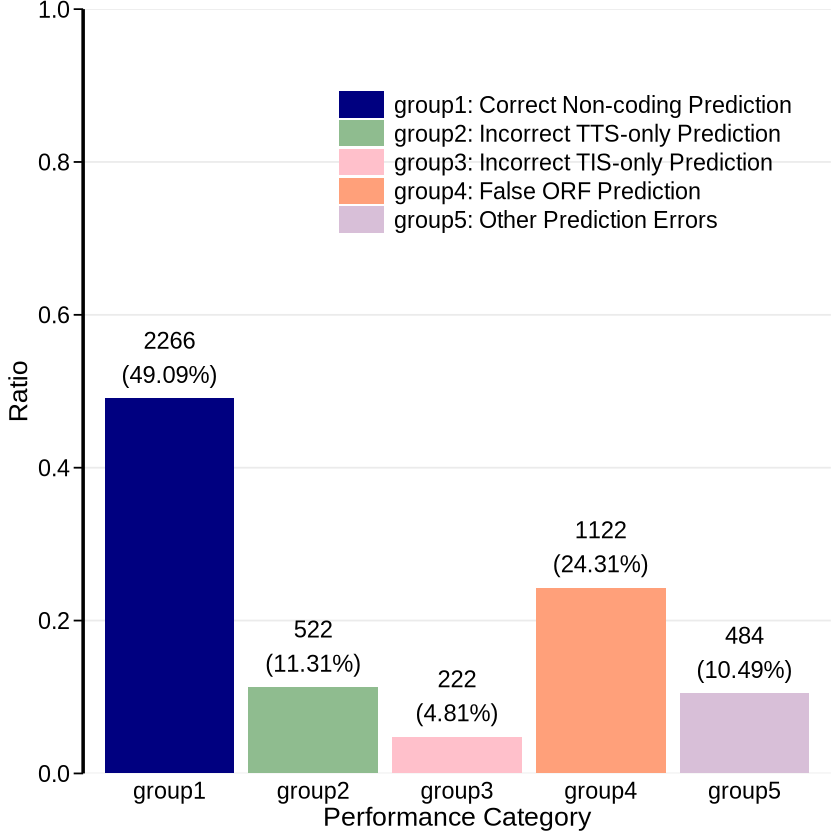

In [6]:
# 示例数据
confusion_data <- matrix(c(
  0, 0, 0,
  0, 0, 0,
  5695, 6972, 10061677
), nrow = 3, byrow = TRUE)

# 调用函数，传入前缀和自定义的混淆矩阵数据
create_and_save_confusion_matrix("TRANSAID_Embedding_batch4_TrainOnlyNM_NR", confusion_data)
generate_and_save_performance_plot("TRANSAID_Embedding_batch4_TrainOnlyNM_NR", confusion_data)
# 使用示例:
 ORF_data_1nr <- list(
          results = list(
         "Correct Non-coding Prediction" = 2266,
         "Incorrect TTS-only Prediction" = 522,
         "Incorrect TIS-only Prediction" = 222,
         "False ORF Prediction"= 1122,
         "Other Prediction Errors" = 484
     ),
     total = 4616
)
plot_transcript_performance(ORF_data_1nr, "TRANSAID_Embedding_batch4_TrainOnlyNM_NR")

Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”


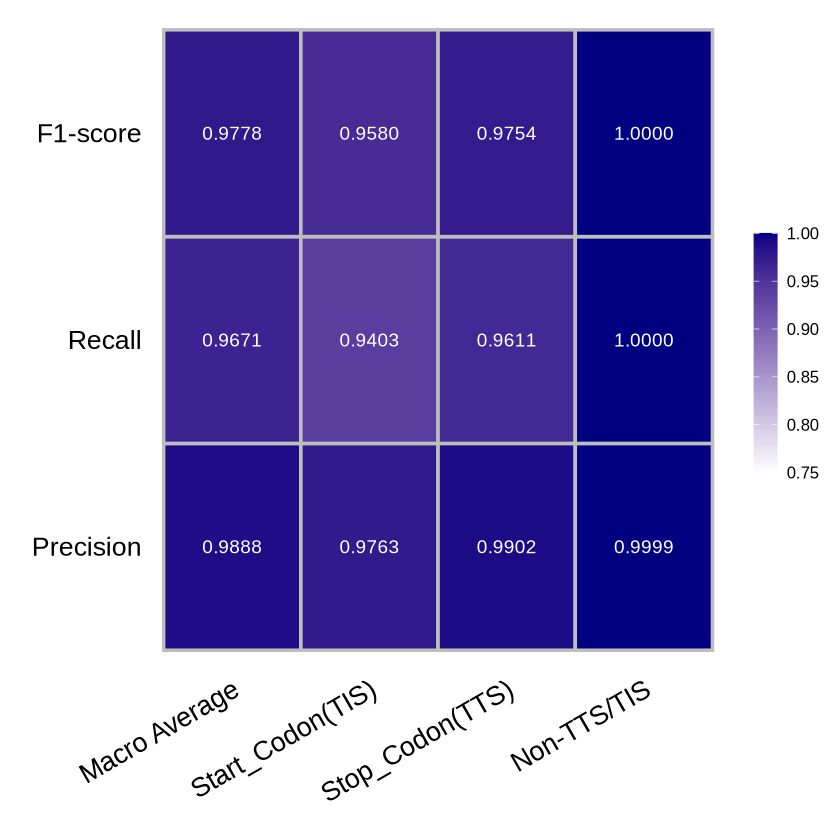

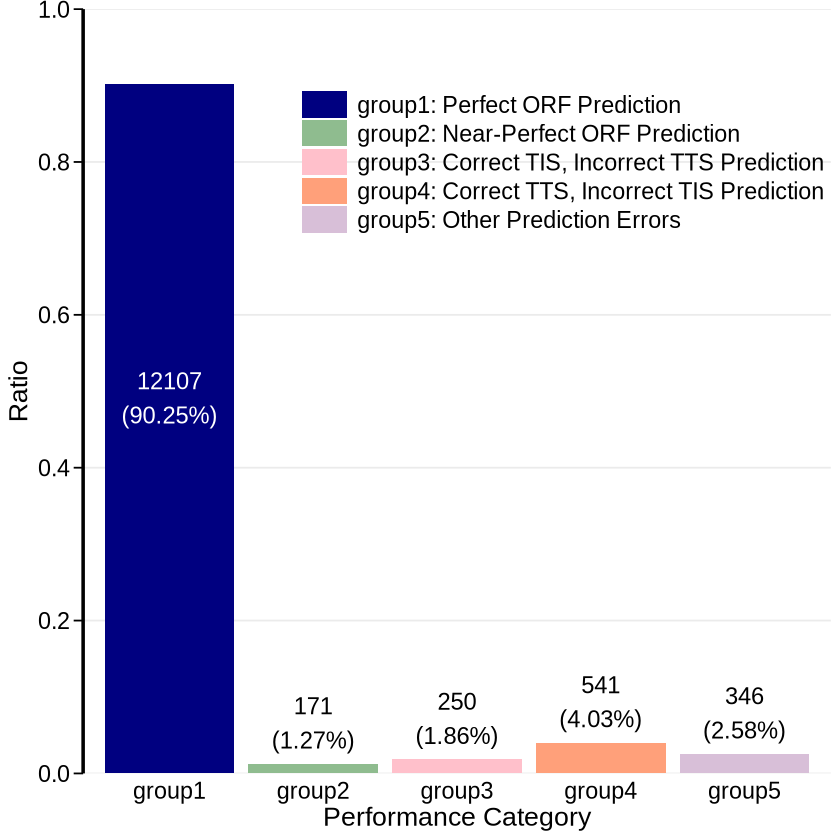

In [7]:
# 示例数据
confusion_data <- matrix(c(
  37841, 2, 2402,
      0, 38678, 1567,
     918, 380, 52704322
), nrow = 3, byrow = TRUE)

# 调用函数，传入前缀和自定义的混淆矩阵数据
create_and_save_confusion_matrix("TRANSAID_Embedding_batch4_NM", confusion_data)
generate_and_save_performance_plot("TRANSAID_Embedding_batch4_NM", confusion_data)
 ORF_data_2nm <- list(
          results = list(
         "Perfect ORF Prediction" = 12107,
         "Near-Perfect ORF Prediction" = 171,
         "Correct TIS, Incorrect TTS Prediction" = 250,
         "Correct TTS, Incorrect TIS Prediction" = 541,
         "Other Prediction Errors" = 346
     ),
     total = 13415
)
plot_transcript_performance(ORF_data_2nm, "TRANSAID_Embedding_batch4_NM")

Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.minor.y` theme element is not defined in the element hierarchy.”
Warning message in plot_theme(plot):
“The `axis.ticks.length.minor.y` theme element is not defined in the element hierarchy.”


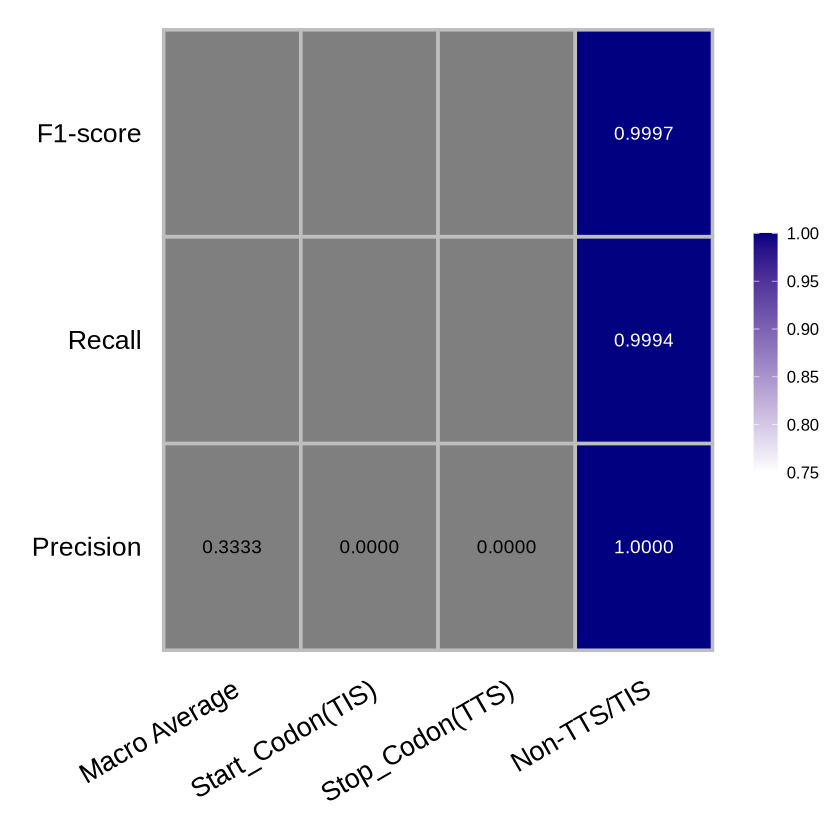

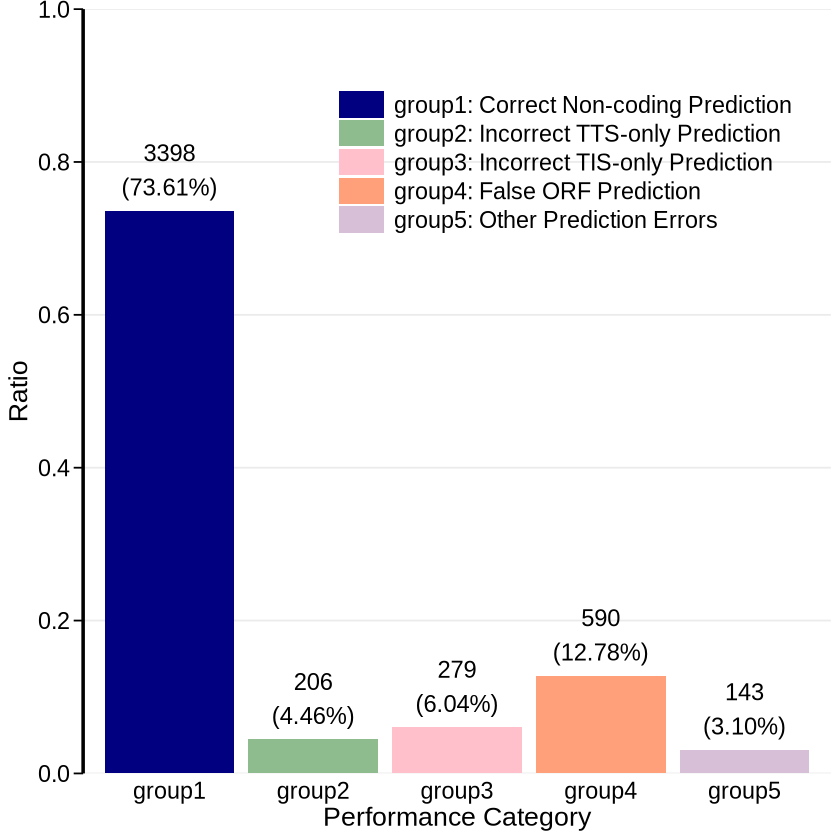

In [8]:
# 示例数据
confusion_data <- matrix(c(
      0, 0, 0,
      0, 0, 0,
     2999, 2734, 10068611
), nrow = 3, byrow = TRUE)

# 调用函数，传入前缀和自定义的混淆矩阵数据
create_and_save_confusion_matrix("TRANSAID_Embedding_batch4_NR", confusion_data)
generate_and_save_performance_plot("TRANSAID_Embedding_batch4_NR", confusion_data)
 ORF_data_2nr <- list(
          results = list(
         "Correct Non-coding Prediction" = 3398,
         "Incorrect TTS-only Prediction" = 206,
         "Incorrect TIS-only Prediction" = 279,
         "False ORF Prediction"= 590,
         "Other Prediction Errors" = 143
     ),
     total = 4616
)
plot_transcript_performance(ORF_data_2nr, "TRANSAID_Embedding_batch4_NR")

In [32]:
# 计算性能指标的函数保持不变
calculate_performance_scores <- function(nm_data, nr_data) {
    nm_accuracy <- (nm_data$results[["Perfect ORF Prediction"]] + 
                   nm_data$results[["Near-Perfect ORF Prediction"]]) / nm_data$total
    nr_accuracy <- nr_data$results[["Correct Non-coding Prediction"]] / nr_data$total
    
    overall_accuracy <- (nm_accuracy * nm_data$total + nr_accuracy * nr_data$total) / 
                       (nm_data$total + nr_data$total)
    balanced_accuracy <- (nm_accuracy + nr_accuracy) / 2
    
    return(list(
        overall_accuracy = overall_accuracy,
        balanced_accuracy = balanced_accuracy,
        nm_accuracy = nm_accuracy,
        nr_accuracy = nr_accuracy
    ))
}

# 计算性能指标
scores_model1 <- calculate_performance_scores(ORF_data_1nm, ORF_data_1nr)
scores_model2 <- calculate_performance_scores(ORF_data_2nm, ORF_data_2nr)

# 准备绘图数据
plot_data <- data.frame(
    model = rep(c("TrainOnlyNM", "TrainWith(NM+NR)"), 2),
    metric = rep(c("Balanced Accuracy", "Overall Accuracy"), each = 2),
    value = c(scores_model1$balanced_accuracy, scores_model2$balanced_accuracy,
             scores_model1$overall_accuracy, scores_model2$overall_accuracy)
)

# 创建条形图
p <- ggplot(plot_data, aes(x = metric, y = value, fill = model)) +
    geom_bar(stat = "identity", position = position_dodge(width = 0.8), width = 0.7) +
    geom_text(aes(label = sprintf("%.2f%%", value* 100, value * 100)),
              position = position_dodge(width = 0.8),
              vjust = -0.5,
              size = 6) +
    scale_fill_manual(values = c("TrainOnlyNM" = "#4169E1",  # 浅一点的蓝色
                                "TrainWith(NM+NR)" = "#000080")) + # navy
    scale_y_continuous(breaks = seq(0, 1, 0.2),
                      limits = c(0, 1),
                      expand = expansion(add = c(0, 0))) +
    labs(#title = "Model Performance Comparison",
         x = "",
         y = "Accuracy",
         fill = "Model Type") +
    theme_minimal() +
    theme(
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
        axis.text.x = element_text(size = 14, color = "black"),
        axis.text.y = element_text(size = 14, color = "black"),
        axis.title = element_text(size = 16),
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black"),
        panel.grid.major.x = element_blank(),
        panel.border = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "top",
        legend.title = element_blank(),
        legend.text = element_text(size = 14),
        axis.line.y = element_line(color = "black", linewidth = 1, arrow = arrow(length = unit(0, "cm")))
    )

# 保存图片
ggsave("model_performance_comparison.png", p, width = 6, height = 6, dpi = 600)

Warning message in sprintf("%.2f%%", value * 100, value * 100):
“one argument not used by format '%.2f%%'”


### Fig2

In [279]:
# pattern_analysis.R

# 加载必要的库
library(rvest)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(grid)
library(stringr)
library(ggtext)

#' 解析HTML文件中的Pattern并保留颜色格式
#'
#' @param html_file HTML文件路径
#' @return data.frame 包含Pattern及其频次的数据框
parse_formatted_patterns <- function(html_file) {
  tryCatch({
    html_content <- read_html(html_file, encoding = "UTF-8")

    # 提取并保留完整的HTML格式
    pattern_cells <- html_content %>%
      html_nodes("table td:nth-child(4)")

    # 更精确的Pattern提取
    pattern_list <- lapply(pattern_cells, function(cell) {
      # 提取每个span元素的完整HTML
      spans <- html_nodes(cell, "span")
      pattern_html <- sapply(spans, function(span) {
        # 保留颜色信息和文本
        color <- html_attr(span, "style")
        text <- html_text(span)
        sprintf("<span style='%s'>%s</span>", color, text)
      })

      # 将所有span组合成完整的pattern
      pattern <- paste(pattern_html, collapse = "")
      text <- html_text(cell)

      list(raw = pattern, text = text)
    })

    # 转换为数据框并统计频次
    pattern_df <- do.call(rbind, lapply(pattern_list, function(x) {
      data.frame(
        pattern_raw = x$raw,
        pattern_text = x$text,
        stringsAsFactors = FALSE
      )
    })) %>%
      group_by(pattern_text, pattern_raw) %>%
      summarise(frequency = n(),.groups = 'drop') %>%
      arrange(desc(frequency))

    # 计算频率
    pattern_df <- pattern_df %>%
      mutate(percentage = frequency / sum(frequency) * 100)

    return(pattern_df)

  }, error = function(e) {
    stop(paste("Error parsing HTML file:", e$message))
  })
}

#' 创建Pattern分布图
#'
#' @param pattern_df Pattern数据框
#' @param prefix 输出文件前缀
#' @param top_n 主图显示的top Pattern数量
#' @param output_dir 输出目录
#' @return ggplot对象
create_pattern_plot <- function(pattern_df, prefix, top_n = 40, output_dir = ".") {
  library(ggtext)

  # 分割数据
  top_patterns <- head(pattern_df, top_n)
  remaining_patterns <- tail(pattern_df, -top_n)

  # 为top_patterns添加序号列
  top_patterns <- top_patterns %>%
    mutate(index = row_number())

  # 创建渐变色板
  n_colors <- top_n
  color_palette <- colorRampPalette(c("#0D1E8F", "#4D69FF"))(n_colors)

  # 计算最大值对应的条件
  max_freq_condition <- top_patterns$frequency == max(top_patterns$frequency)

  # 主图
  main_plot <- ggplot(top_patterns, 
                     aes(x = reorder(pattern_raw, -frequency), 
                         y = frequency,
                         fill = factor(index))) +  
    geom_bar(stat = "identity") +
    scale_fill_manual(values = color_palette) +
    geom_text(aes(label = sprintf("%d\n%.2f%%", frequency, percentage)),
              vjust = -0.25,  
              size = 2) +
    theme_minimal() +
    theme(
      axis.text.x = element_markdown(angle = 45, 
                                hjust = 1, 
                                size = 8, 
                                family = "mono"),
      plot.title = element_text(hjust = 0.5, size = 14),
      plot.margin = margin(t = 30, 
                           r = 40, 
                           b = 20, 
                           l = 20),
      legend.position = "none",
      axis.line.y = element_line(color = "black", 
                                linewidth = 1, 
                                arrow = arrow(length = unit(0, "cm"))),
      axis.ticks.y = element_line(color = "black", 
                                linewidth = 0.5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank()
    ) +
    labs(
      #title = paste(prefix, "Top", top_n, "Pattern Frequencies"),
      x = "Error Pattern",
      y = "Frequency"
    ) +
    coord_cartesian(ylim = c(0, max(top_patterns$frequency)*1.07),  
                    xlim = c(-0.1, top_n + 0.5), expand = FALSE)

  # 副图
  inset_plot <- ggplot(remaining_patterns %>% arrange(desc(frequency)), 
                      aes(x = reorder(pattern_raw, -frequency), 
                          y = frequency)) +
    geom_bar(stat = "identity", fill = "#A4C2FF", alpha = 0.7) +
    theme_minimal() +
    theme(
      axis.text.x = element_markdown(angle = 45, 
                                hjust = 1, 
                                size = 3, 
                                family = "mono"),
      axis.title = element_blank(),
      plot.title = element_text(size = 10, color = "black"),  
      plot.margin = margin(1, 1, 1, 1),
      plot.background = element_rect(fill = "white", color = "gray80"),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank(),
      panel.grid.minor.y = element_blank(),
      panel.grid.major.y = element_blank()
    ) +
    labs(title = paste("Remaining Patterns (after top", top_n, ")")) +
    coord_cartesian(ylim = c(0, max(remaining_patterns$frequency)), expand = FALSE)

  # 组合图形
  final_plot <- main_plot +
    annotation_custom(
      ggplotGrob(inset_plot),
      xmin = top_n * 0.2,
      xmax = top_n,
      ymin = max(top_patterns$frequency) * 0.3,
      ymax = max(top_patterns$frequency) * 0.96
    )

  # 保存图片
  output_file <- file.path(output_dir, 
                          paste0(prefix, "_pattern_distribution.png"))
  ggsave(output_file, final_plot, 
         width = 15, 
         height = 5, 
         units = "in", 
         dpi = 300)

  # 保存统计结果
  stats_file <- file.path(output_dir, 
                         paste0(prefix, "_pattern_statistics.csv"))
  write.csv(pattern_df, stats_file, row.names = FALSE)

  return(final_plot)
}

#' Pattern分析主函数
#'
#' @param html_file HTML文件路径
#' @param prefix 输出文件前缀
#' @param output_dir 输出目录
#' @param top_n 主图显示的top Pattern数量
#' @return list 包含分析结果和图形对象
analyze_patterns <- function(html_file, prefix, output_dir = ".", top_n = 20) {
  dir.create(output_dir, showWarnings = FALSE, recursive = TRUE)

  pattern_df <- parse_formatted_patterns(html_file)

  cat("\nPattern Analysis Results:\n")
  cat("Total unique patterns:", nrow(pattern_df), "\n")
  cat("Most frequent pattern count:", max(pattern_df$frequency), "\n")

  plot <- create_pattern_plot(pattern_df, prefix, top_n, output_dir)

  return(list(
    data = pattern_df,
    plot = plot,
    stats = list(
      total_patterns = nrow(pattern_df),
      max_frequency = max(pattern_df$frequency),
      unique_patterns = length(unique(pattern_df$pattern_text))
    )
  ))
}

In [280]:
# 调用示例
html_file <- "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_heatmap/TRANSAID_Embedding_batch4_NM_non_matching_formatted_sequences.html"
prefix <- "TRANSAID_Embedding_batch4_NM"
output_dir <- "/home/jovyan/work/insilico_translation/script_for_drawing"

# 运行分析
results <- analyze_patterns(
  html_file = html_file,
  prefix = prefix,
  output_dir = output_dir,
  top_n = 40
)

# 查看结果
print(results$stats)


Pattern Analysis Results:
Total unique patterns: 168 
Most frequent pattern count: 221 
$total_patterns
[1] 168

$max_frequency
[1] 221

$unique_patterns
[1] 156



In [281]:
# 调用示例
html_file <- "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_heatmap/TRANSAID_Embedding_batch4_NR_non_matching_formatted_sequences.html"
prefix <- "TRANSAID_Embedding_batch4_NR"
output_dir <- "/home/jovyan/work/insilico_translation/script_for_drawing"

# 运行分析
results <- analyze_patterns(
  html_file = html_file,
  prefix = prefix,
  output_dir = output_dir,
  top_n = 40
)

# 查看结果
print(results$stats)


Pattern Analysis Results:
Total unique patterns: 110 
Most frequent pattern count: 290 
$total_patterns
[1] 110

$max_frequency
[1] 290

$unique_patterns
[1] 101



In [204]:
library(ggplot2)
library(dplyr)
library(reticulate)

In [277]:
# 绘制概率分布的函数（对应Python代码中的`plot_distribution`函数）
plot_distribution <- function(p1_probs, p2_probs, p3_probs) {
    # 准备数据框，将不同类型的概率数据合并到一起，并添加类型标识列
    data <- data.frame(
        value = c(p1_probs, p2_probs, p3_probs),
        type = rep(c("TIS\nnon-zero", "TTS\nnon-zero", "Non-TIS/TTS\nnon-one"), 
                   c(length(p1_probs), length(p2_probs), length(p3_probs)))
    )
    
    # 使用ggplot2绘制小提琴图（类似Python中violinplot的效果）
    p <- ggplot(data, aes(x = type, y = value, fill = type)) +
        geom_violin(trim = FALSE, alpha = 0.3) +
        # 设置填充颜色，这里按照类型设置不同颜色，对应Python代码中设置小提琴图颜色的逻辑
        scale_fill_manual(values = c("gray", "red", "blue")) +
        # 添加散点图（使用抖动效果避免重叠，模拟Python中添加散点图的逻辑）
        geom_jitter(width = 0.1, alpha = 0.2) +
        # 设置标题、坐标轴标签等图表样式
        labs(title = "Distribution of Non-zero/Non-one Probabilities",
             y = "Probability") +
        theme_minimal() +
        theme(legend.position = "none")
    
    # 计算并添加统计信息文本（均值和标准差等，类似Python代码中添加统计信息的逻辑）
    stats_text <- paste0(
        "Statistics (mean ± std):\n",
        sprintf("TIS: %.4f ± %.4f (n=%d)\n", mean(p1_probs), sd(p1_probs), length(p1_probs)),
        sprintf("TTS: %.4f ± %.4f (n=%d)\n", mean(p2_probs), sd(p2_probs), length(p2_probs)),
        sprintf("Non-TIS/TTS: %.4f ± %.4f (n=%d)\n", mean(p3_probs), sd(p3_probs), length(p3_probs))
    )
    p <- p + annotate("text", x = 1.5, y = min(data$value), label = stats_text, hjust = 0, vjust = -1, size = 3)
    
    print(p)
}

# 分析转录本概率并可视化的主函数（对应Python代码中的`analyze_transcript_probabilities`函数）
analyze_transcript_probabilities <- function(pkl_file, target_id = NULL, num_transcripts = NULL, plot_type = 'both', 
                                               output_path = ".", file_prefix = "default", cutoff = 0.01) {
    print("Loading libraries...")
    print(paste("cutoff",as.character(cutoff)))
    pickle <- import("pickle",)
    builtins <- import_builtins()
    np <- import("numpy")  # 添加numpy导入
    
    print("Reading pickle file...")
    with(builtins$open(pkl_file, "rb") %as% file, {
        data <- pickle$load(file)
    })
    print(paste("Loaded", length(data), "records"))
    
    p1_probs <- c()
    p2_probs <- c()
    p3_probs <- c()
    
    n <- 0
    found_target <- FALSE
    
    for (i in 1:length(data)) {
        item <- data[[i]]
        
        # 检查target_id
        if (!is.null(target_id)) {
            if (item$transcript_id == target_id) {
                found_target <- TRUE
                print(paste("Found target:", target_id))
                print("Analyzing predictions...")
                
                # 转换预测概率数组
                probs_array <- np$array(item$predictions_probs)
                if (length(dim(probs_array))!= 2) {
                    stop("Unexpected shape for predictions_probs")
                }
                
                print(paste("Shape of predictions:", paste(dim(probs_array), collapse="x")))
                
                # 检查非零概率
                for (j in 1:nrow(probs_array)) {
                    if (probs_array[j, 3] < 0.95) {
                        print(paste0(j, ": ", paste(probs_array[j, ], collapse=", ")))
                    }
                }
            } else {
                next
            }
        } else {
            probs_array <- np$array(item$predictions_probs)
        }
        
        # 确保probs_array有正确的维度
        if (length(dim(probs_array))!= 2 || ncol(probs_array)!= 3) {
            warning(paste("Skipping record", i, "due to invalid probability array shape"))
            next
        }
        
        # 获取概率数据
        positions <- 1:nrow(probs_array)
        
        # 收集概率值
        p1_probs <- c(p1_probs, probs_array[, 1][probs_array[, 1] > cutoff])
        p2_probs <- c(p2_probs, probs_array[, 2][probs_array[, 2] > cutoff])
        p3_probs <- c(p3_probs, probs_array[, 3][probs_array[, 3] < (1-cutoff)])
        
        # 绘制概率图
        if (plot_type %in% c('prob', 'both')) {
            plot_data <- data.frame(
                positions = positions,
                tis_probs = probs_array[, 1],
                tts_probs = probs_array[, 2],
                non_tis_tts_probs = probs_array[, 3]
            )
            
            print("Creating probability plot...")
            # 修改绘图部分代码
            p <- ggplot(plot_data, aes(x = positions)) +
                # TIS点
                geom_point(aes(y = tis_probs, 
                            color = "TIS", 
                            size = factor(tis_probs > cutoff, 
                                        labels = c("≤cutoff", ">cutoff"))), 
                        alpha = 0.5) +
                # TTS点
                geom_point(aes(y = tts_probs, 
                            color = "TTS", 
                            size = factor(tts_probs > cutoff, 
                                        labels = c("≤cutoff", ">cutoff"))), 
                        alpha = 0.5) +
                # Non-TIS/TTS点
                geom_point(aes(y = non_tis_tts_probs, 
                            color = "Non-TIS/TTS", 
                            size = factor(non_tis_tts_probs < (1-cutoff), 
                                        labels = c("≤cutoff", ">cutoff"))), 
                        alpha = 0.5) +
                # 设置颜色
                scale_color_manual(values = c("gray", "red", "blue")) +
                # 设置点大小
                scale_size_manual(values = c(0.5, 2)) +
                # 设置标题和标签
                labs(title = paste0("Prediction Probabilities for ", item$transcript_id),
                    x = "Sequence Position",
                    y = "Probability",
                    color = "Type",
                    size = "Probability") +
                # 设置主题和其他元素
                theme_minimal() +
                theme(
                    # 调整legend整体位置和布局
                    legend.position = "top",
                    legend.box = "horizontal",
                    legend.spacing.x = unit(60, "pt"),  # 增加Type和Probability之间的间距
                    # 调整legend内部的间距
                    legend.key.width = unit(0.7, "lines"),  # 减小图例符号的宽度
                    legend.key.height = unit(0.7, "lines"), # 减小图例符号的高度
                    legend.key.spacing = unit(2, "pt"),     # 减小同一组内图例项之间的间距
                    # 调整legend中的文字大小
                    legend.title = element_text(size = 8),  # 设置legend标题大小
                    legend.text = element_text(size = 7),   # 设置legend文本大小
                    
                    # 保持其他设置不变
                    axis.line.y = element_line(color = "black", 
                                            linewidth = 1, 
                                            arrow = arrow(length = unit(0, "cm"))),
                    axis.ticks.y = element_line(color = "black", 
                                            linewidth = 0.5)
                ) +
                # 修改legend标题
                labs(title = paste0("Prediction Probabilities for ", item$transcript_id),
                    x = "Sequence Position",
                    y = "Probability",
                    color = "Type",
                    size = "Probability    ") +  # 在标题后添加空格来增加间距
                coord_cartesian(ylim = c(0, 1), 
                            xlim = c(-0.01*max(positions), max(positions)), 
                            expand = FALSE)
            print(p)
            ggsave(filename = paste0(output_path, "/", file_prefix, "_probability_plot_", item$transcript_id, ".png"), 
                   plot = p, width =6, height = 3)
        }
        
        n <- n + 1
        
        if (!is.null(target_id) && found_target) {
            break
        }
        
        if (is.null(target_id) &&!is.null(num_transcripts) && n >= num_transcripts) {
            break
        }
    }
    
    if (!is.null(target_id) &&!found_target) {
        stop(paste0("Transcript ", target_id, " not found in predictions"))
    }
    
    # 绘制概率分布
    if (plot_type %in% c('box', 'both') && length(p1_probs) > 0) {
        print("Creating distribution plot...")
        plot_distribution(p1_probs, p2_probs, p3_probs)
        # 保存概率分布图到指定路径
        ggsave(filename = paste0(output_path, "/", file_prefix, "_distribution_plot.png"), 
               plot = last_plot(), width = 8, height = 6)
    }
}

[1] "Loading libraries..."
[1] "cutoff 0.01"
[1] "Reading pickle file..."
[1] "Loaded 3398 records"
[1] "Found target: NR_160788"
[1] "Analyzing predictions..."
[1] "Shape of predictions: 1530x3"
[1] "226: 0.0830603986978531, 0.000157782676978968, 0.916781723499298"
[1] "227: 0.0677113756537437, 0.000157179063535295, 0.932131350040436"
[1] "228: 0.0710755661129951, 9.97848837869242e-05, 0.928824603557587"
[1] "979: 3.55976067112351e-06, 0.369633257389069, 0.63036322593689"
[1] "980: 1.12542522856529e-06, 0.456779539585114, 0.543219387531281"
[1] "981: 2.04307389140013e-06, 0.31915083527565, 0.68084716796875"
[1] "Creating probability plot..."


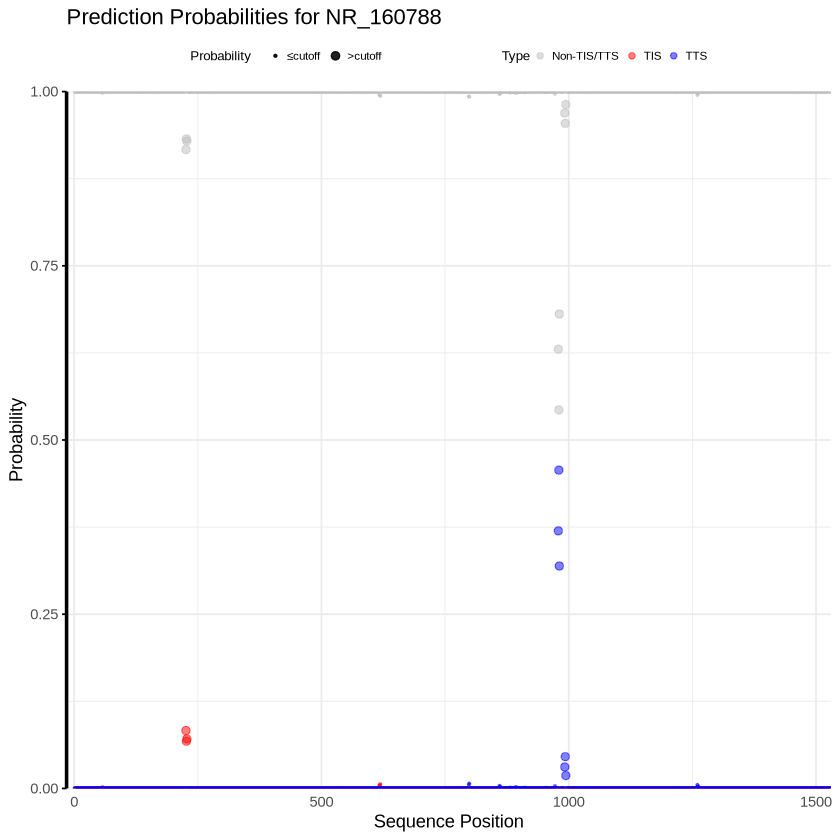

In [278]:
# 使用示例
pkl_NR_match <- "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_matching_predictions.pkl"
pkl_NR_nonMatch <- "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NR_non_matching_predictions.pkl"
#pkl_NM_match <- "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_matching_predictions.pkl"
#pkl_NM_nonMatch <- "/home/jovyan/work/insilico_translation/embedding_type3_maxlen9995_ratio80_NM_NR/TRANSAID_Embedding_batch4_NM_non_matching_predictions.pkl"

if (!file.exists(pkl_NR_match)) {
    stop(paste0("The specified pkl file does not exist: ", pkl_file_path))
}
output_path <- "/home/jovyan/work/insilico_translation/script_for_drawing"  # 替换为实际的输出路径
file_prefix <- "NR_160788"  # 替换为实际的文件前缀
analyze_transcript_probabilities(pkl_file = pkl_NR_match, target_id="NR_160788", plot_type='prob', file_prefix=file_prefix, cutoff =0.01)